# Calculate statistics for a set of records

Summarise (roll up) test results into new statistical data records. 

In this example, the tests are stored in *Tensile Test Data* table and the statistical data is stored in *Tensile Statistical Data*. Since the sample data is arranged by specimen, the mean and other statistics will be stored by specimen in the new record.

Statistical data is commonly stored using meta-attributes. Here, we store the mean of each property as the attribute value, and statistical results (*Minimum*, *Maximum*, *Median*, *Range* and *Standard Deviation*) as its meta-attributes whenever possible.

## Define a function which rolls up an attribute

Create a function to calculate statistics for, and store the values on the meta-attributes of, a target attribute.

The `rollup_point_attribute()` method below is a general example which will work whether meta-attributes are present or not, or if the number of samples is too small to provide meaningful statistics. It checks if each named meta-attribute exists, then sets existing meta-attributes and updates them by calling `Record.set_attributes()`.

To simplify your own roll-up, you can:

* Make sure there are meta-attributes for roll-up statistics on all relevant attributes when setting up a Granta MI schema.
* Make sure all the target attributes in your script have the same meta-attributes.
* Set up a workflow where all statistical data records are created new.

In [1]:
import statistics
from typing import List
from GRANTA_MIScriptingToolkit import granta as mpy

def rollup_point_attribute(source_attributes: List[mpy.AttributeValue],
                           target_attribute: mpy.AttributeValue, record: mpy.Record) -> None:
    assert all([len(attr.points) <= 1 for attr in source_attributes]), \
        "Multi-valued points are not supported by this script"

    values = [attr.points[0] for attr in source_attributes if attr.points]

    if len(values) == 0:
        return

    target_attribute.unit = source_attributes[0].unit
    target_attribute.points = [statistics.mean(values)]
    updated_meta_attributes = []

    if 'Minimum' in target_attribute.meta_attributes:
        target_attribute.meta_attributes['Minimum'].points = [min(values)]
        target_attribute.meta_attributes['Minimum'].unit = target_attribute.unit
        updated_meta_attributes.append('Minimum')

    if 'Maximum' in target_attribute.meta_attributes:
        target_attribute.meta_attributes['Maximum'].points = [max(values)]
        target_attribute.meta_attributes['Maximum'].unit = target_attribute.unit
        updated_meta_attributes.append('Maximum')

    if 'Median' in target_attribute.meta_attributes:
        target_attribute.meta_attributes['Median'].points = [statistics.median(values)]
        target_attribute.meta_attributes['Median'].unit = target_attribute.unit
        updated_meta_attributes.append('Median')

    if 'Number of Samples' in target_attribute.meta_attributes:
        target_attribute.meta_attributes['Number of Samples'].value = len(values)
        updated_meta_attributes.append('Number of Samples')

    if 'Range' in target_attribute.meta_attributes:
        target_attribute.meta_attributes['Range'].points = [max(values) - min(values)]
        target_attribute.meta_attributes['Range'].unit = target_attribute.unit
        updated_meta_attributes.append('Range')

    if len(values) > 2 and 'Standard Deviation' in target_attribute.meta_attributes:
        target_attribute.meta_attributes['Standard Deviation'].points = [statistics.stdev(values)]
        target_attribute.meta_attributes['Standard Deviation'].unit = target_attribute.unit
        updated_meta_attributes.append('Standard Deviation')

    record.set_attributes([target_attribute] + 
                          [target_attribute.meta_attributes[updated_meta] for updated_meta in updated_meta_attributes])

## Define a function which copies attribute values

Define a `copy_attribute()` function which copies an attribute value from the source records, for example a *Specimen ID* stored in a short-text attribute, or a test temperature. 

This example supports several attribute types, and could easily be extended to support others such as discrete or hyperlink.

In [2]:
def copy_attribute(source_attributes: List[mpy.AttributeValue],
                   target_attribute: mpy.AttributeValue, record: mpy.Record) -> None:
    if target_attribute.type == 'POIN':
        assert all([len(attr.points) == 1 for attr in source_attributes]), \
            "Multi-valued points are not supported by this script"
        values = set([attr.points[0] for attr in source_attributes if attr.points])
        assert len(values) == 1, "Values must be identical to copy, received '{0}'".format(', '.join(values))
        target_attribute.points = [values.pop()]
    elif target_attribute.type == 'DISC':
        values = set([val for attr in source_attributes for val in attr.value if attr.value])
        assert len(values) == 1, "Values must be identical to copy, received '{0}'".format(', '.join(values))
        target_attribute.value = [values.pop()]
    else:
        values = set([attr.value for attr in source_attributes if attr.value])
        assert len(values) == 1, "Values must be identical to copy, received '{0}'".format(', '.join(values))
        target_attribute.value = values.pop()
    record.set_attributes([target_attribute])

## Get test data from Granta MI

Composite data in Granta MI is stored according to layup orientation and *Specimen ID*. The roll-up process retains
the overall structure of the records, but creates a single new record for each specimen.

Connect to Granta MI and fetch the folder corresponding to the composite *3M, S-Glass Unitape S2/SP381*:

In [3]:
s = mpy.Session('localhost', autologon=True)
db = s.get_db('MI Training')
test_table = db.get_table('Tensile Test Data')
statistics_table = db.get_table('Tensile Statistical Data')

material_record = test_table.search_for_records_by_name('3M, S-Glass Unitape S2/SP381')[0]
print(material_record)

<Record long name:3M, S-Glass Unitape S2/SP381>


To make processing easier, convert the structure of the data from

    Material => Orientation => RTD => Specimen => Test result

to a dictionary with each layer indexed by name (removing the redundant layers):

    { Orientation name :
        { Specimen name :
            [ Test 1,
              Test 2 ...
            ]
        }
    }

Although this structure is sufficient for this example, a network library or tree wrapper class might be better suited to dealing with advanced tree-traversal.

In [4]:
orientation_records = material_record.children
test_records = {
    orientation.name: {
        specimen.name: specimen.children for specimen in
        test_table.get_records_from_path(orientation, ['RTD'], use_short_names=True)}
    for orientation in orientation_records
}

Define the attributes you want to calculate statistics for, and those you want to copy from the test records.

To fetch large numbers of records or attributes efficiently, use the `table.bulk_fetch()` method (see [Example 19 - Streamlined API Performance Tuning](../streamlined/19_Streamlined_API_performance_tuning.ipynb)).

In [5]:
attributes_to_rollup = ["Ultimate Tensile Strength",
                        "Young's Modulus (11-axis)"]
attributes_to_copy = ["Test Temperature",
                      "Test Type",
                      "Material designation",
                      "Composite system type",
                      "Specimen ID",
                      "Test Environment"]

test_table.bulk_fetch([test
                       for orientation in test_records.values()
                       for specimen in orientation.values()
                       for test in specimen],
                       attributes_to_copy + attributes_to_rollup)

Create box-plots for three of the specimens using the `seaborn` plotting libraries, first 'flattening' the data into a usable list of `numpy` arrays.

Alternatively, you could convert the data into a `pandas` DataFrame at this point (useful if you needed to process the data further).

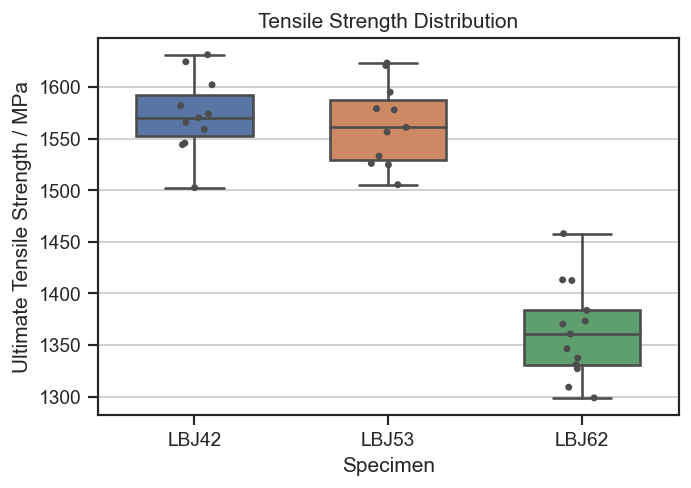

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 125

specimens_to_plot = ['LBJ42', 'LBJ53', 'LBJ62']
specimen_data = {specimen_name: test_records['0° tension'][specimen_name] for specimen_name in specimens_to_plot}
plot_data = [
    np.array([test.attributes['Ultimate Tensile Strength'].points[0] for test in specimen])
    for specimen in specimen_data.values()
]

y_unit = test_table.attributes['Ultimate Tensile Strength'].unit

sns.set(context='notebook', style='ticks')
f, ax = plt.subplots()
sns.boxplot(data=plot_data, width=0.6)
sns.stripplot(data=plot_data, size=4, color=".3", linewidth=0)

ax.set_xticklabels(specimens_to_plot)
ax.set_ylabel('Ultimate Tensile Strength / {0}'.format(y_unit))
ax.set_xlabel('Specimen')
ax.set_title('Tensile Strength Distribution')
ax.yaxis.grid(True)
plt.show()

Perform the roll-up by creating the new records and iterating through the attributes defined above, copying or rolling up as required. Here we've used the `table.path_from()` method to create a folder path and each new roll-up record.

Finally, use `Session.update()` to write the new record to the server, then set and update links between the new statistical data record and the test records it summarises.

In [7]:
import datetime
timestamp = datetime.datetime.utcnow().isoformat()
for orientation, specimens in test_records.items():
    for specimen, test_runs in specimens.items():
        rollup_record = statistics_table.path_from(None,
                                                   ['Epoxy/Glass', '3M, S-Glass Unitape S2/SP381',
                                                    timestamp,
                                                    orientation,
                                                    'RTD'],
                                                   specimen,
                                                   color='Aqua')
        for rollup in attributes_to_rollup:
            source_attributes = [test_run.attributes[rollup] for test_run in test_runs]
            try:
                target_attribute = rollup_record.attributes[rollup]
                rollup_point_attribute(source_attributes, target_attribute, rollup_record)
            except AssertionError:
                continue
            except KeyError:
                print("No attribute in target table to roll attribute '{0}' into.".format(rollup))
                continue

        for copy_attr in attributes_to_copy:
            source_attributes = [test_run.attributes[copy_attr] for test_run in test_runs]
            try:
                target_attribute = rollup_record.attributes[copy_attr]
                copy_attribute(source_attributes, target_attribute, rollup_record)
            except AssertionError:
                continue
            except KeyError:
                print("No attribute in target table to copy attribute '{0}' into.".format(copy_attr))
                continue

        rollup_record = s.update([rollup_record])[0]
        rollup_record.set_links('Tensile Test Data', test_runs)

        rollup_record = s.update_links([rollup_record])[0]
        print("Rollup completed for the specimen '{0}', view this record at '{1}'".format(rollup_record.name,
                                                                                          rollup_record.viewer_url))

Rollup completed for the specimen 'LBU15', view this record at 'http://localhost/mi/datasheet.aspx?dbKey=MI_Training&recordHistoryGuid=f8cdd4b6-9e4b-4f15-a645-2c26dc1b11fb'
Rollup completed for the specimen 'LBU14', view this record at 'http://localhost/mi/datasheet.aspx?dbKey=MI_Training&recordHistoryGuid=97e78fc6-e94a-4cba-85c8-b5f6043a6fb0'
Rollup completed for the specimen 'LBJ83', view this record at 'http://localhost/mi/datasheet.aspx?dbKey=MI_Training&recordHistoryGuid=66c70cb4-f154-401d-bd47-18ac16e88972'
Rollup completed for the specimen 'LBJ62', view this record at 'http://localhost/mi/datasheet.aspx?dbKey=MI_Training&recordHistoryGuid=92e815d7-c6df-4d4d-bcd4-f139e70365e1'
Rollup completed for the specimen 'LBJ53', view this record at 'http://localhost/mi/datasheet.aspx?dbKey=MI_Training&recordHistoryGuid=4978bbe2-9616-4f3d-a38d-093f7add0c63'
Rollup completed for the specimen 'LBJ42', view this record at 'http://localhost/mi/datasheet.aspx?dbKey=MI_Training&recordHistoryGuid=